# Climate and Commodity Analysis: Master Dataset Template

This notebook provides a template for analyzing the master climate and commodity dataset. It includes:

1. Loading the master dataset
2. Subsetting data by commodity
3. Basic data exploration and visualization
4. Setting up a Random Forest model
5. Template sections for other data science methods

## Import Libraries

In [33]:
pip install scikit-learn

     |████████████████████████████████| 11.1 MB 6.1 MB/s eta 0:00:01
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
     |████████████████████████████████| 30.3 MB 15.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/Apexr/Documents/Climate_Project/Machine_Learning/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Try to import scikit-learn packages
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    sklearn_available = True
except ImportError:
    print("Warning: scikit-learn is not installed. Machine learning functions will not be available.")
    print("To install, run: pip install scikit-learn")
    sklearn_available = False

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Load Master Dataset

The master dataset contains all commodity prices and their associated climate variables.

In [35]:
# Path to the master dataset
data_path = '../data_files/MASTER_climate_commodity_data.csv'

# Load the dataset
df = pd.read_csv(data_path)

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nAvailable commodities:")
commodity_cols = [col for col in df.columns if col.endswith('_Price')]
for commodity in commodity_cols:
    print(f"- {commodity.replace('_Price', '')}")

# Display the first few rows
df.head()

Dataset shape: (95, 86)
Date range: 2015-02-01 00:00:00 to 2022-12-01 00:00:00

Available commodities:
- Wheat
- Cocoa
- Rice
- Soybeans
- Coffee
- Maize
- Cotton


,Year,Month,Wheat_Price,Cocoa_Price,Rice_Price,Soybeans_Price,Coffee_Price,Maize_Price,Cotton_Price,Wheat_Region,Cocoa_Region,Rice_Region,Soybeans_Region,Coffee_Region,Maize_Region,Cotton_Region,Wheat_temperature_C,Wheat_precip_m,Wheat_dewpoint_C,Wheat_relative_humidity,Wheat_temp_anomaly,Wheat_precip_anomaly,Wheat_temp_3m_avg,Wheat_precip_3m_sum,Wheat_drought_index,Wheat_heat_stress,Cocoa_temperature_C,Cocoa_precip_m,Cocoa_dewpoint_C,Cocoa_relative_humidity,Cocoa_temp_anomaly,Cocoa_precip_anomaly,Cocoa_temp_3m_avg,Cocoa_precip_3m_sum,Cocoa_drought_index,Cocoa_heat_stress,Rice_temperature_C,Rice_precip_m,Rice_dewpoint_C,Rice_relative_humidity,Rice_temp_anomaly,Rice_precip_anomaly,Rice_temp_3m_avg,Rice_precip_3m_sum,Rice_drought_index,Rice_heat_stress,Soybeans_temperature_C,Soybeans_precip_m,Soybeans_dewpoint_C,Soybeans_relative_humidity,Soybeans_temp_anomaly,Soybeans_precip_anomaly,Soybeans_temp_3m_avg,Soybeans_precip_3m_sum,Soybeans_drought_index,Soybeans_heat_stress,Coffee_temperature_C,Coffee_precip_m,Coffee_dewpoint_C,Coffee_relative_humidity,Coffee_temp_anomaly,Coffee_precip_anomaly,Coffee_temp_3m_avg,Coffee_precip_3m_sum,Coffee_drought_index,Coffee_heat_stress,Maize_temperature_C,Maize_precip_m,Maize_dewpoint_C,Maize_relative_humidity,Maize_temp_anomaly,Maize_precip_anomaly,Maize_temp_3m_avg,Maize_precip_3m_sum,Maize_drought_index,Maize_heat_stress,Cotton_temperature_C,Cotton_precip_m,Cotton_dewpoint_C,Cotton_relative_humidity,Cotton_temp_anomaly,Cotton_precip_anomaly,Cotton_temp_3m_avg,Cotton_precip_3m_sum,Cotton_drought_index,Cotton_heat_stress
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-01,2015,2,201.742069,2961.935714,409.500000,364.739239,178.888500,173.758866,69.842500,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,25.938013,0.021711,19.968565,69.716495,-2.634213,0.000163,25.938013,0.021711,0.263584,29.423837,30.146202,0.040482,23.713093,68.580399,1.324871,-0.009216,30.146202,0.040482,-0.141703,33.575222,26.982498,0.030509,20.657769,68.408091,0.470796,0.004697,26.982498,0.030509,-0.042383,30.402902,14.269318,0.005841,9.113065,71.151334,1.043072,-0.007197,14.269318,0.005841,-0.111504,17.826885,22.072321,0.038221,17.746410,76.520422,-0.608285,-0.006239,22.072321,0.038221,0.054590,25.898342,27.739582,0.031813,22.084914,71.417513,0.478354,0.003123,27.739582,0.031813,-0.044712,31.310458,24.473500,0.024623,17.390874,64.743134,-2.004087,-0.005370,24.473500,0.024623,0.195039,27.710657
2015-03-01,2015,3,202.691427,2878.033167,400.727273,359.595560,160.735909,174.293821,69.352273,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,30.267190,0.022776,24.297743,70.536420,0.114860,-0.001884,28.102601,0.044487,-0.013370,33.794011,27.706814,0.053458,21.273705,68.098480,-1.546187,0.002868,28.926508,0.093940,0.157487,31.111738,26.694945,0.028264,20.370216,68.350895,-1.143673,-0.000082,26.838721,0.058773,0.114285,30.112490,11.179879,0.010875,6.023626,70.542550,-0.410643,-0.001187,12.724599,0.016716,0.039878,14.707006,23.006479,0.044857,18.680568,76.668287,0.350725,-0.002067,22.539400,0.083078,-0.037140,26.839893,28.747019,0.032787,23.092351,71.601167,0.386766,0.002788,28.243301,0.064600,-0.035889,32.327078,28.214707,0.023812,21.132081,65.545173,0.221311,-0.005282,26.344103,0.048435,-0.027413,31.491965
2015-04-01,2015,4,195.931228,2868.274454,392.409091,356.925677,163.997727,172.151577,71.702500,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,27.174480,0.023657,21.205033,69.953842,-0.604942,0.000875,27.793228,0.068144,0.061369,30.672172,28.287590,0.049797,21.854482,68.214125,-0.590174,-0.003297,28.713535,0.143738,0.055720,31.698296,27.378898,0.030846,21.054170,68.486707,0.128293,0.001015,27.018780,0.089618,-0.011815,30.803233,11.992816,0.012307,6.836563,70.704447,-1.125529,0.000819,12.480671,0.029023,0.113372,15.528038,23.735533,0.042551,19.409622,76.782773,1.46173

## Subset Data by Commodity

This function allows you to easily extract data for a specific commodity.

In [36]:
def subset_commodity_data(df, commodity_name):
    """
    Extract data for a specific commodity including its price and climate variables.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The master dataset
    commodity_name : str
        Name of the commodity (e.g., 'Coffee', 'Wheat')
    
    Returns:
    --------
    pandas.DataFrame
        Subset of data with price and climate variables for the specified commodity
    """
    # Get the price column
    price_col = f"{commodity_name}_Price"
    
    # Get all climate columns for this commodity
    climate_cols = [col for col in df.columns if col.startswith(f"{commodity_name}_") and col != price_col]
    
    # Get the region column
    region_col = f"{commodity_name}_Region"
    
    # Create a new dataframe with the selected columns
    # Include Year and Month columns for seasonal analysis
    subset_cols = ['Year', 'Month', price_col, region_col] + climate_cols
    subset_df = df[subset_cols].copy()
    
    # Rename columns to simpler names
    rename_dict = {price_col: 'Price', region_col: 'Region'}
    for col in climate_cols:
        rename_dict[col] = col.replace(f"{commodity_name}_", "")
    
    subset_df.rename(columns=rename_dict, inplace=True)
    
    print(f"Extracted data for {commodity_name}")
    print(f"Shape: {subset_df.shape}")
    print(f"Climate variables: {len(climate_cols)}")
    
    return subset_df

# Example: Extract data for Coffee
coffee_df = subset_commodity_data(df, 'Coffee')
coffee_df.head()

Extracted data for Coffee
Shape: (95, 15)
Climate variables: 11


,Year,Month,Price,Region,Region,temperature_C,precip_m,dewpoint_C,relative_humidity,temp_anomaly,precip_anomaly,temp_3m_avg,precip_3m_sum,drought_index,heat_stress
Date,,,,,,,,,,,,,,,
2015-02-01,2015,2,178.888500,COLOMBIA,COLOMBIA,22.072321,0.038221,17.746410,76.520422,-0.608285,-0.006239,22.072321,0.038221,0.054590,25.898342
2015-03-01,2015,3,160.735909,COLOMBIA,COLOMBIA,23.006479,0.044857,18.680568,76.668287,0.350725,-0.002067,22.539400,0.083078,-0.037140,26.839893
2015-04-01,2015,4,163.997727,COLOMBIA,COLOMBIA,23.735533,0.042551,19.409622,76.782773,1.461737,0.000227,22.938111,0.125629,-0.145947,27.574672
2015-05-01,2015,5,158.482857,COLOMBIA,COLOMBIA,22.505558,0.042275,18.179647,76.589162,0.878784,0.004725,23.082523,0.129683,-0.083154,26.335017
2015-06-01,2015,6,159.755000,COLOMBIA,COLOMBIA,18.911091,0.037704,14.585180,76.010106,-1.350715,0.005359,21.717394,0.122530,0.140431,22.711597


## Basic Data Exploration

Extracted data for Coffee
Shape: (95, 15)
Climate variables: 11


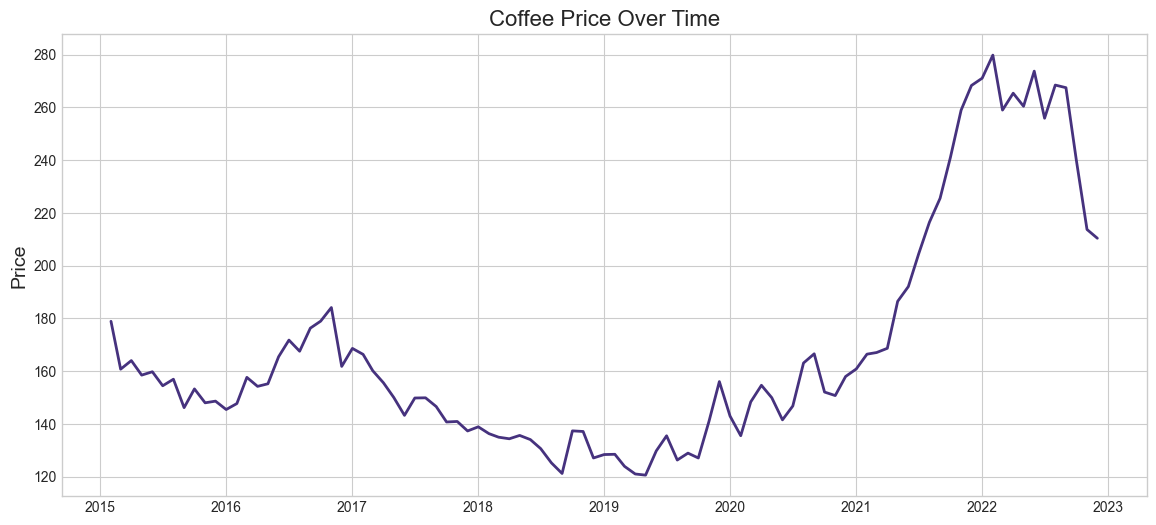

,mean,std,min,max
Year,,,,
2015,157.201624,9.173287,146.146818,178.888500
2016,163.839985,12.370254,145.434762,184.115455
2017,150.755953,10.131089,137.306190,168.612727
2018,132.714927,5.518084,121.180000,138.876087
2019,130.555761,9.821539,120.549130,156.029091
2020,150.831950,8.901431,135.500500,166.564545
2021,204.694029,37.524889,160.819524,268.329130
2022,255.465902,22.631677,210.388636,279.833500


In [37]:
# Select a commodity for exploration
commodity = 'Coffee'  # Change this to explore different commodities
commodity_df = subset_commodity_data(df, commodity)

# Price over time
plt.figure(figsize=(14, 6))
plt.plot(commodity_df.index, commodity_df['Price'], linewidth=2)
plt.title(f'{commodity} Price Over Time', fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

# Price statistics by year
yearly_stats = commodity_df.groupby('Year')['Price'].agg(['mean', 'std', 'min', 'max'])
yearly_stats

## Correlation Analysis

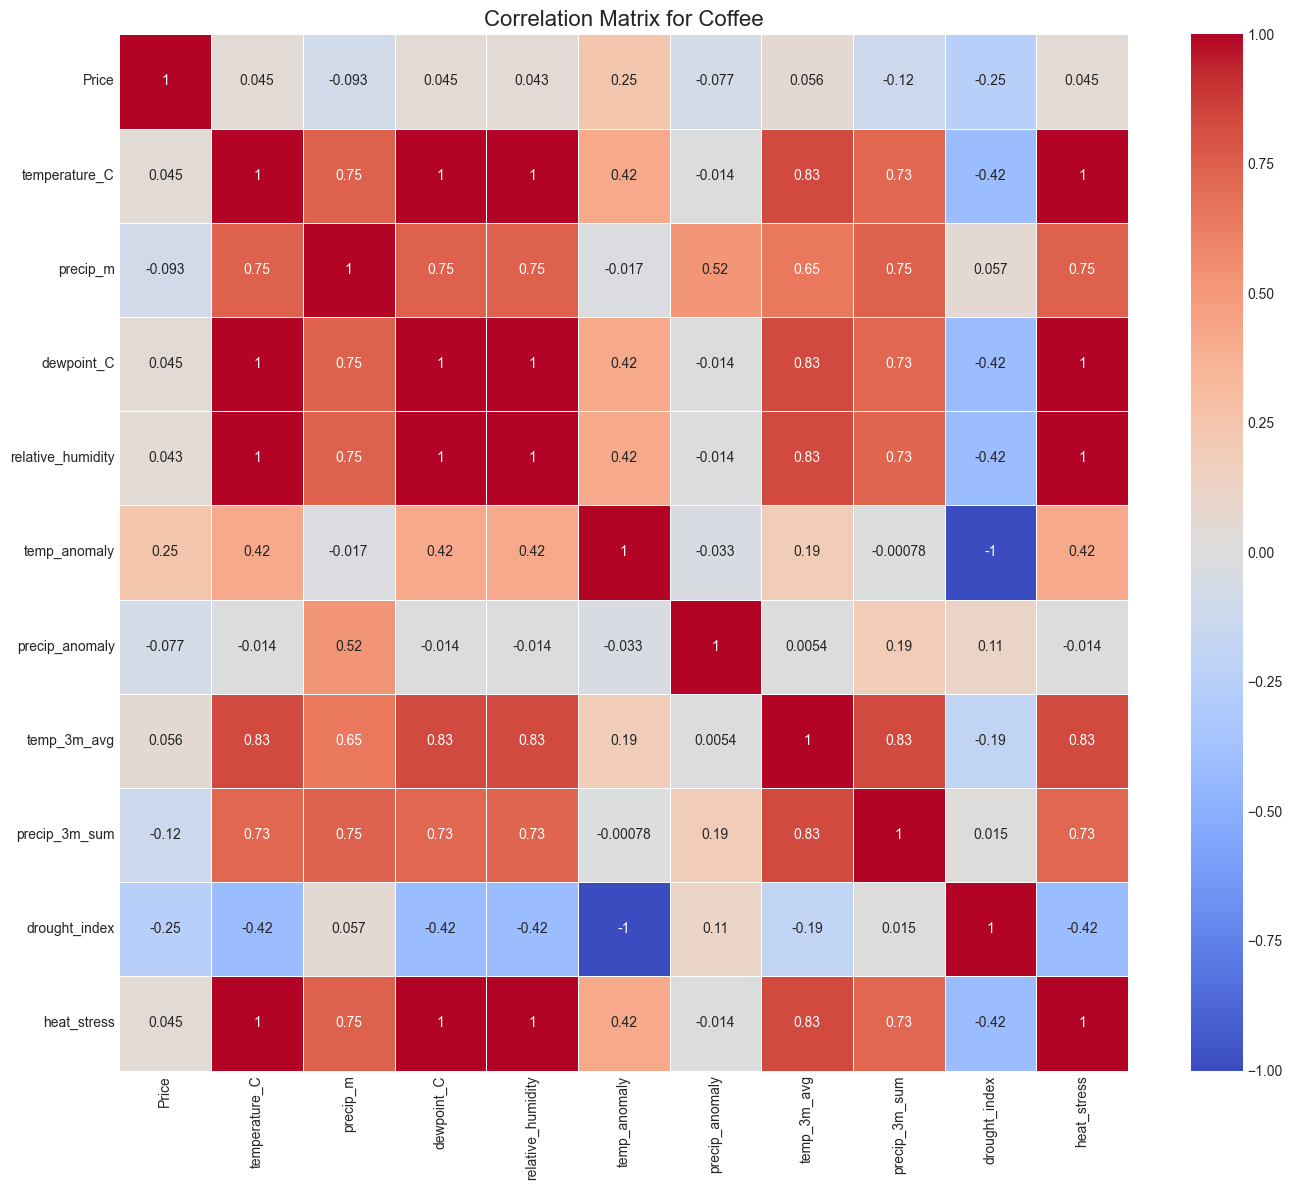

Top climate variables correlated with price:
temp_anomaly         0.245825
temp_3m_avg          0.056071
temperature_C        0.045444
dewpoint_C           0.045444
heat_stress          0.045427
relative_humidity    0.043260
precip_anomaly      -0.076741
precip_m            -0.092608
precip_3m_sum       -0.120244
drought_index       -0.250400
Name: Price, dtype: float64


In [38]:
# Calculate correlations between price and climate variables
# Exclude non-numeric columns
exclude_cols = ['Year', 'Month', 'Region']
numeric_cols = [col for col in commodity_df.columns if col not in exclude_cols]
correlation_matrix = commodity_df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title(f'Correlation Matrix for {commodity}', fontsize=16)
plt.tight_layout()
plt.show()

# Get top correlations with price
price_correlations = correlation_matrix['Price'].drop('Price').sort_values(ascending=False)
print("Top climate variables correlated with price:")
print(price_correlations.head(10))

## Time-lagged Correlations

Calculate correlations between price and climate variables with time lags.

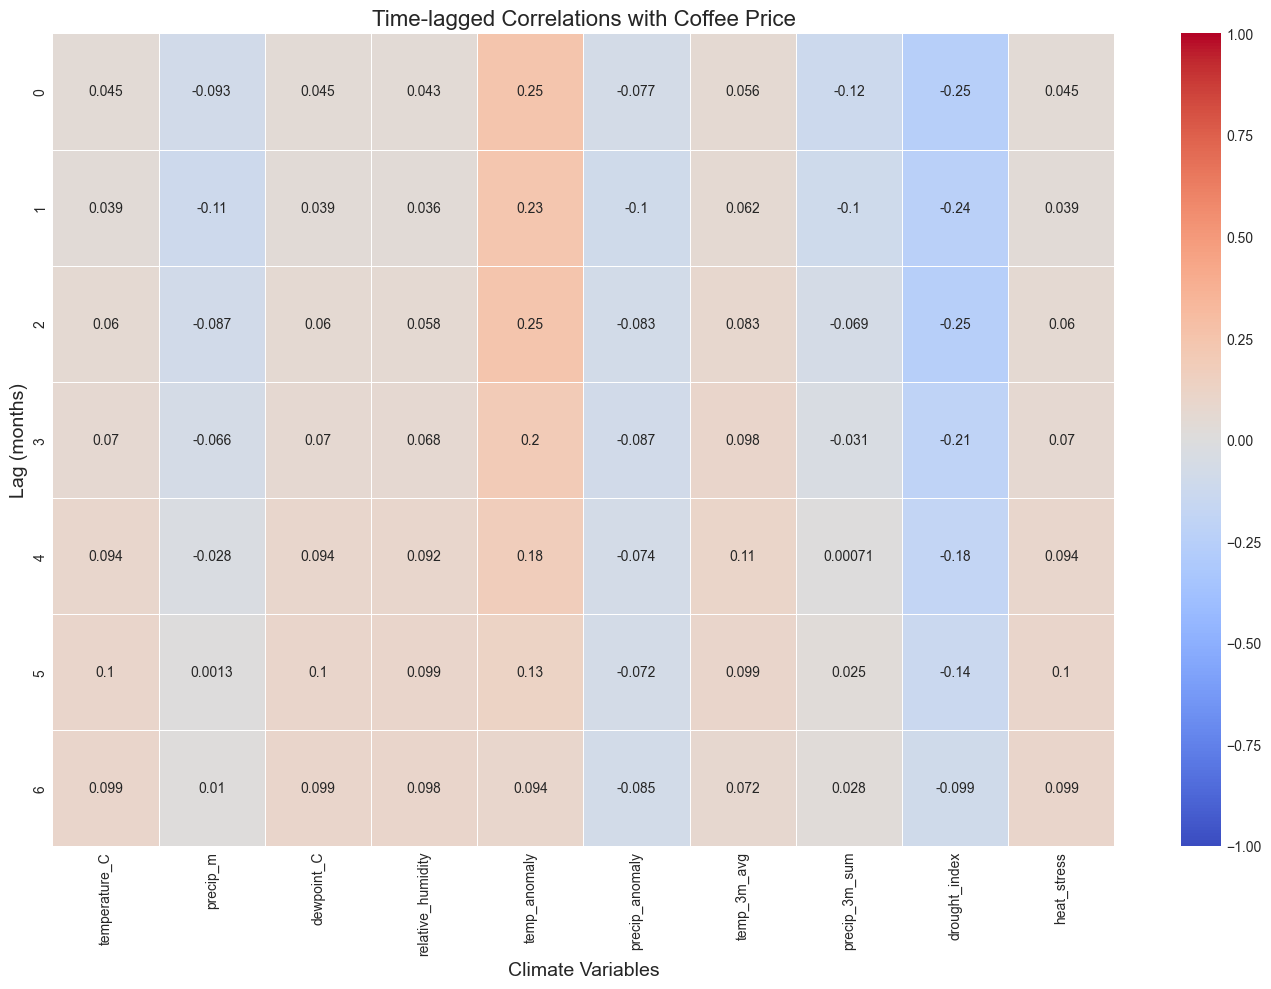

In [39]:
def calculate_time_lagged_correlations(df, target_col='Price', max_lag=6):
    """
    Calculate correlation between target column and other features with time lags.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset
    target_col : str
        Target column name (default: 'Price')
    max_lag : int
        Maximum number of lags to consider (default: 6)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with time-lagged correlations
    """
    # Exclude non-numeric columns and the target column
    exclude_cols = ['Year', 'Month', 'Region', target_col]
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Initialize results dictionary
    lag_corrs = {}
    
    # Calculate correlations for each lag
    for lag in range(max_lag + 1):
        lag_corrs[lag] = {}
        for col in feature_cols:
            # Create lagged feature
            lagged_df = df.copy()
            lagged_df[f'{col}_lag_{lag}'] = lagged_df[col].shift(lag)
            
            # Calculate correlation
            lag_corrs[lag][col] = lagged_df[[target_col, f'{col}_lag_{lag}']].corr().iloc[0, 1]
    
    # Convert to DataFrame
    lag_corrs_df = pd.DataFrame(lag_corrs).T
    
    return lag_corrs_df

# Calculate time-lagged correlations
lagged_corrs = calculate_time_lagged_correlations(commodity_df, max_lag=6)

# Plot heatmap of time-lagged correlations
plt.figure(figsize=(14, 10))
sns.heatmap(lagged_corrs, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title(f'Time-lagged Correlations with {commodity} Price', fontsize=16)
plt.xlabel('Climate Variables', fontsize=14)
plt.ylabel('Lag (months)', fontsize=14)
plt.tight_layout()
plt.show()

## Random Forest Model Setup

Set up a Random Forest model to predict commodity prices based on climate variables.

In [40]:
# Check if scikit-learn is available
if 'sklearn_available' in globals() and sklearn_available:
    def prepare_data_for_modeling(df, target_col='Price', test_size=0.2, include_lags=True, max_lag=3):
        """
        Prepare data for modeling by creating lagged features and splitting into train/test sets.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset
        target_col : str
            Target column name (default: 'Price')
        test_size : float
            Proportion of data to use for testing (default: 0.2)
        include_lags : bool
            Whether to include lagged features (default: True)
        max_lag : int
            Maximum number of lags to include (default: 3)
        
        Returns:
        --------
        tuple
            (X_train, X_test, y_train, y_test, feature_names)
        """
        # Make a copy of the dataframe
        model_df = df.copy()
        
        # Exclude non-numeric columns and the target column
        exclude_cols = ['Year', 'Month', 'Region', target_col]
        feature_cols = [col for col in model_df.columns if col not in exclude_cols]
        
        # Create lagged features if required
        if include_lags:
            for col in feature_cols:
                for lag in range(1, max_lag + 1):
                    model_df[f'{col}_lag_{lag}'] = model_df[col].shift(lag)
            
            # Update feature columns to include lagged features
            feature_cols = [col for col in model_df.columns if col not in exclude_cols + [target_col]]
            
            # Drop rows with NaN values (due to lagging)
            model_df = model_df.dropna()
        
        # Add seasonal features
        model_df['sin_month'] = np.sin(2 * np.pi * model_df['Month'] / 12)
        model_df['cos_month'] = np.cos(2 * np.pi * model_df['Month'] / 12)
        feature_cols.extend(['sin_month', 'cos_month'])
        
        # Prepare features and target
        X = model_df[feature_cols]
        y = model_df[target_col]
        
        # Split the data chronologically
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Convert back to DataFrame to preserve column names
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_cols

    # Prepare data for the selected commodity
    X_train, X_test, y_train, y_test, feature_names = prepare_data_for_modeling(commodity_df, include_lags=True, max_lag=3)

    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Number of features: {len(feature_names)}")
    
else:
    print("Warning: scikit-learn is not available. Machine learning functions cannot be executed.")
    print("To enable these features, install scikit-learn with: pip install scikit-learn")
    print("\nYou can still perform data exploration and visualization with the existing data.")

Training data shape: (73, 42)
Testing data shape: (19, 42)
Number of features: 42


## Train Random Forest Model

In [41]:
# Check if scikit-learn is available
if 'sklearn_available' in globals() and sklearn_available:
    # Define the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.2f}")
    print(f"Testing R²: {test_r2:.2f}")
else:
    print("Warning: scikit-learn is not available. Random Forest model cannot be trained.")
    print("To enable this feature, install scikit-learn with: pip install scikit-learn")

Training RMSE: 6.60
Testing RMSE: 100.68
Training R²: 0.82
Testing R²: -13.45


## Plot Actual vs Predicted Prices

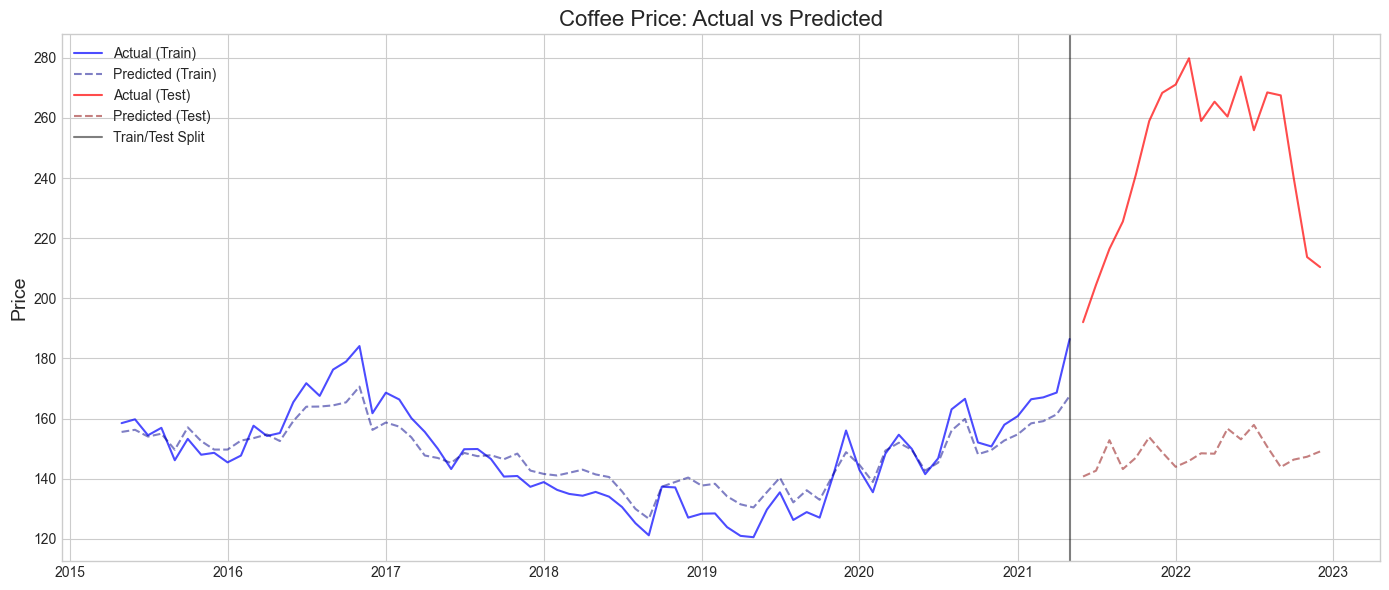

In [42]:
# Check if scikit-learn is available and model was trained
if 'sklearn_available' in globals() and sklearn_available and 'rf_model' in globals():
    # Create a DataFrame with actual and predicted values
    results_df = pd.DataFrame({
        'Actual': pd.concat([y_train, y_test]),
        'Predicted': np.concatenate([y_pred_train, y_pred_test]),
        'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test)
    })

    # Get the original index
    results_df.index = pd.concat([y_train, y_test]).index

    # Plot the results
    plt.figure(figsize=(14, 6))
    plt.plot(results_df[results_df['Set'] == 'Train'].index, results_df[results_df['Set'] == 'Train']['Actual'], 
             label='Actual (Train)', color='blue', alpha=0.7)
    plt.plot(results_df[results_df['Set'] == 'Train'].index, results_df[results_df['Set'] == 'Train']['Predicted'], 
             label='Predicted (Train)', color='darkblue', linestyle='--', alpha=0.5)
    plt.plot(results_df[results_df['Set'] == 'Test'].index, results_df[results_df['Set'] == 'Test']['Actual'], 
             label='Actual (Test)', color='red', alpha=0.7)
    plt.plot(results_df[results_df['Set'] == 'Test'].index, results_df[results_df['Set'] == 'Test']['Predicted'], 
             label='Predicted (Test)', color='darkred', linestyle='--', alpha=0.5)

    plt.axvline(x=X_train.index[-1], color='black', linestyle='-', alpha=0.5, label='Train/Test Split')
    plt.title(f'{commodity} Price: Actual vs Predicted', fontsize=16)
    plt.ylabel('Price', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Model predictions not available. Train a Random Forest model first.")
    print("If scikit-learn is not installed, run: pip install scikit-learn")

## Feature Importance

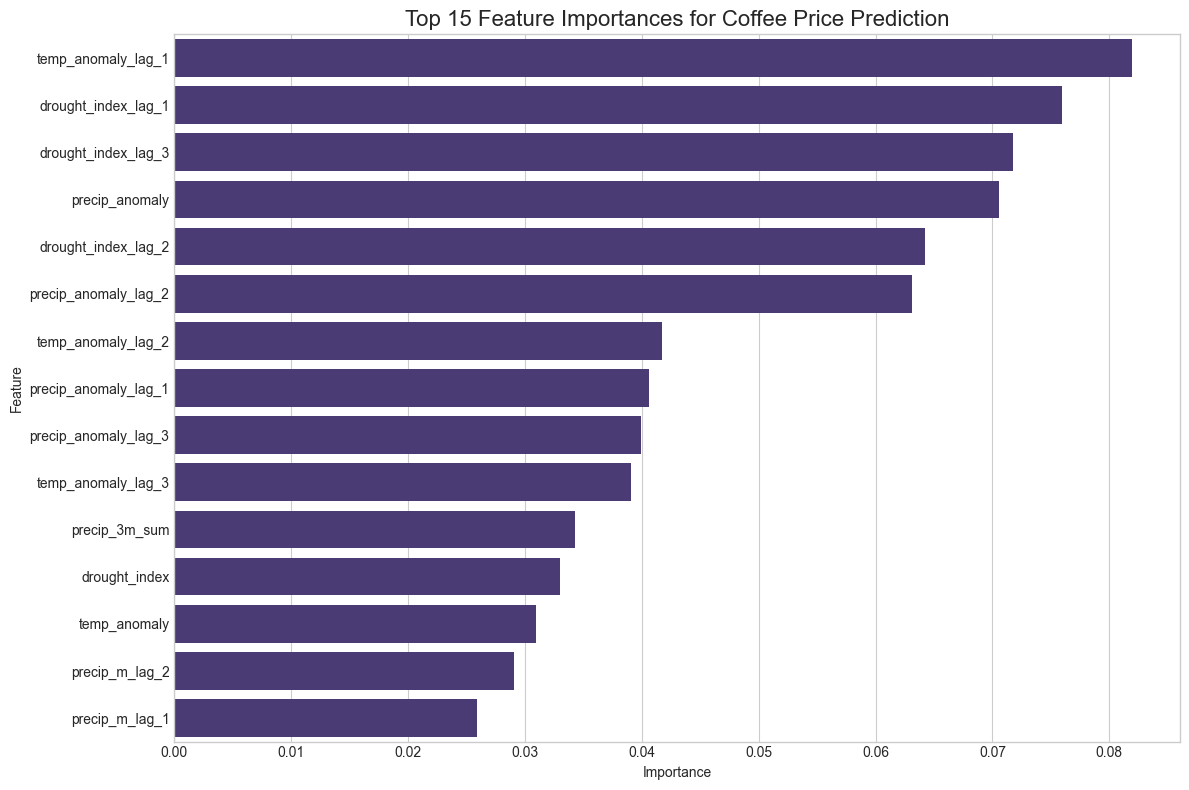

In [43]:
# Check if scikit-learn is available and model was trained
if 'sklearn_available' in globals() and sklearn_available and 'rf_model' in globals():
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Plot feature importance (top 15)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Feature Importances for {commodity} Price Prediction', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Display the top 15 important features
    feature_importance.head(15)
else:
    print("Warning: Feature importance not available. Train a Random Forest model first.")
    print("If scikit-learn is not installed, run: pip install scikit-learn")

## Hyperparameter Tuning (Optional)

Tune the hyperparameters of the Random Forest model using GridSearchCV.

In [26]:
# Check if scikit-learn is available
if 'sklearn_available' in globals() and sklearn_available:
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Define the time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Create the grid search
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    print("GridSearchCV is set up but not executed to save time.")
    print("To run the grid search, uncomment the following lines:")
    print("# Fit the grid search")
    print("# grid_search.fit(X_train, y_train)")
    print("# Get the best parameters")
    print("# print('Best parameters:', grid_search.best_params_)")
    print("# Get the best model")
    print("# best_model = grid_search.best_estimator_")
else:
    print("Warning: scikit-learn is not available. Hyperparameter tuning cannot be performed.")
    print("To enable this feature, install scikit-learn with: pip install scikit-learn")

To enable this feature, install scikit-learn with: pip install scikit-learn


## Other Data Science Methods Template

Here are template sections for other data science methods you can use with this dataset.

### 1. Time Series Decomposition

Decompose the time series into trend, seasonal, and residual components.

In [27]:
# Try to import statsmodels
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    statsmodels_available = True
    
    # Uncomment to run time series decomposition
    # result = seasonal_decompose(commodity_df['Price'], model='additive', period=12)
    # 
    # # Plot the decomposition
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
    # result.observed.plot(ax=ax1)
    # ax1.set_title('Observed')
    # result.trend.plot(ax=ax2)
    # ax2.set_title('Trend')
    # result.seasonal.plot(ax=ax3)
    # ax3.set_title('Seasonal')
    # result.resid.plot(ax=ax4)
    # ax4.set_title('Residual')
    # plt.tight_layout()
    
except ImportError:
    statsmodels_available = False
    print("Warning: statsmodels is not installed. Time series decomposition will not be available.")
    print("To install, run: pip install statsmodels")
    
    # Alternative manual decomposition using pandas rolling functions
    print("\nAlternative: You can use pandas rolling functions for simple trend analysis:")
    print("commodity_df['trend'] = commodity_df['Price'].rolling(window=12).mean()")
    print("commodity_df['Price'].plot(label='Original')")
    print("commodity_df['trend'].plot(label='Trend (12-month rolling avg)')")
    print("plt.legend()")
    print("plt.show()")

To install, run: pip install statsmodels

Alternative: You can use pandas rolling functions for simple trend analysis:
commodity_df['trend'] = commodity_df['Price'].rolling(window=12).mean()
commodity_df['Price'].plot(label='Original')
commodity_df['trend'].plot(label='Trend (12-month rolling avg)')
plt.legend()
plt.show()


### 2. ARIMA Modeling

Build an ARIMA model to forecast commodity prices.

In [28]:
# Try to import ARIMA-related packages
try:
    from statsmodels.tsa.arima.model import ARIMA
    arima_available = True
    
    # Try to import pmdarima (auto_arima) if available
    try:
        import pmdarima as pm
        auto_arima_available = True
        
        # Uncomment to run auto_arima
        # # Automatically find the best ARIMA parameters
        # auto_arima = pm.auto_arima(
        #     commodity_df['Price'], 
        #     seasonal=True, 
        #     m=12,
        #     d=None, 
        #     start_p=0, 
        #     start_q=0,
        #     max_p=5, 
        #     max_q=5, 
        #     information_criterion='aic',
        #     trace=True,
        #     error_action='ignore',
        #     suppress_warnings=True,
        #     stepwise=True
        # )
        # 
        # # Get the best parameters
        # print(f"Best ARIMA parameters: {auto_arima.order}")
        # print(f"Best seasonal parameters: {auto_arima.seasonal_order}")
        
    except ImportError:
        auto_arima_available = False
        print("Note: pmdarima (auto_arima) is not installed. Manual ARIMA parameter selection will be required.")
        print("To install, run: pip install pmdarima")
        
    # Example of manual ARIMA model if auto_arima is not available
    if not auto_arima_available:
        print("\nAlternative: You can use manual ARIMA model:")
        print("# Fit ARIMA model")
        print("model = ARIMA(commodity_df['Price'], order=(1, 1, 1))")
        print("fit_model = model.fit()")
        print("print(fit_model.summary())")
        print("# Forecast")
        print("forecast = fit_model.forecast(steps=12)")
        print("# Plot forecast")
        print("plt.figure(figsize=(12, 6))")
        print("plt.plot(commodity_df.index, commodity_df['Price'], label='Observed')")
        print("forecast_index = pd.date_range(start=commodity_df.index[-1], periods=13, freq='M')[1:]")
        print("plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')")
        print("plt.legend()")
        print("plt.show()")
        
except ImportError:
    arima_available = False
    print("Warning: statsmodels is not installed. ARIMA modeling will not be available.")
    print("To install, run: pip install statsmodels pmdarima")

To install, run: pip install statsmodels pmdarima


### 3. Neural Network (LSTM) for Time Series Forecasting

Build an LSTM model to forecast commodity prices.

In [29]:
# Try to import TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tensorflow_available = True
    
    # Example of LSTM modeling
    # Function to create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)
    
    # Uncomment to create and train an LSTM model
    # # Prepare data for LSTM (example)
    # # Scale the data
    # scaler = MinMaxScaler()
    # scaled_data = scaler.fit_transform(commodity_df[['Price'] + [col for col in commodity_df.columns if col not in ['Year', 'Month', 'Region']]])
    # 
    # # Create sequences
    # seq_length = 12  # 12 months lookback
    # X, y = create_sequences(scaled_data, seq_length)
    # 
    # # Split data
    # train_size = int(len(X) * 0.8)
    # X_train, X_test = X[:train_size], X[train_size:]
    # y_train, y_test = y[:train_size], y[train_size:]
    # 
    # # Build LSTM model
    # model = Sequential()
    # model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    # model.add(LSTM(50, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(1))
    # 
    # # Compile and train
    # model.compile(optimizer='adam', loss='mse')
    # early_stop = EarlyStopping(monitor='val_loss', patience=10)
    # history = model.fit(
    #     X_train, y_train,
    #     epochs=100,
    #     batch_size=32,
    #     validation_split=0.2,
    #     callbacks=[early_stop],
    #     verbose=1
    # )
    
except ImportError:
    tensorflow_available = False
    print("Warning: TensorFlow is not installed. LSTM modeling will not be available.")
    print("To install, run: pip install tensorflow")
    print("\nAlternative: You can use simpler sequential models with scikit-learn if available.")
    if 'sklearn_available' in globals() and sklearn_available:
        print("For example, try TimeSeriesRegressor from sklearn:")
        print("from sklearn.multioutput import MultiOutputRegressor")
        print("from sklearn.ensemble import RandomForestRegressor")
        print("# Create a time series regressor")
        print("base_model = RandomForestRegressor(n_estimators=100, random_state=42)")
        print("model = MultiOutputRegressor(base_model)")
        print("# Train on lagged features")

To install, run: pip install tensorflow

Alternative: You can use simpler sequential models with scikit-learn if available.


### 4. Cluster Analysis

Cluster the data to identify patterns.

In [30]:
# Import required libraries
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.metrics import silhouette_score

# Example of cluster analysis
# # Prepare data for clustering
# # (implementation details would go here)

### 5. Principal Component Analysis (PCA)

Reduce dimensionality and identify principal components.

In [31]:
# Import required libraries
# from sklearn.decomposition import PCA

# Example of PCA
# # Prepare data for PCA
# # (implementation details would go here)

## Instructions for Further Analysis

This notebook provides a template for analyzing the master climate and commodity dataset. Here are instructions for extending this analysis with your own data science methods:

### 1. Working with Different Commodities

To analyze a different commodity:
```python
# Change the commodity name
commodity = 'Wheat'  # Options: 'Coffee', 'Cocoa', 'Wheat', 'Maize', 'Rice', 'Soybeans', 'Cotton'
commodity_df = subset_commodity_data(df, commodity)
```

### 2. Feature Engineering

You can create additional features based on the existing climate variables:
```python
# Create new features
commodity_df['temp_precip_ratio'] = commodity_df['temperature_C'] / commodity_df['precip_m']
commodity_df['heat_stress_squared'] = commodity_df['heat_stress'] ** 2
```

### 3. Model Selection

Experiment with different models beyond Random Forest:
```python
# Linear regression
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
```

### 4. Time Series Forecasting

For more advanced time series forecasting, consider using:
- Prophet (Facebook/Meta's forecasting tool)
- SARIMA (Seasonal ARIMA)
- Neural Prophet
- Deep learning models (LSTM, GRU, Transformer)

### 5. Multi-commodity Analysis

To analyze relationships between multiple commodities:
```python
# Extract prices for all commodities
prices_df = df[[col for col in df.columns if col.endswith('_Price')]]
prices_df.columns = [col.replace('_Price', '') for col in prices_df.columns]

# Calculate correlations between commodity prices
price_correlations = prices_df.corr()
```

### 6. Advanced Visualization

Create more sophisticated visualizations:
```python
# Interactive plots with Plotly
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(commodity_df.reset_index(), x='Date', y='Price')
fig.show()
```

### 7. Saving Your Models

Save trained models for future use:
```python
import joblib

# Save the model
joblib.dump(rf_model, f'../models/{commodity}_rf_model.pkl')

# Load the model
loaded_model = joblib.load(f'../models/{commodity}_rf_model.pkl')
```

### 8. Deploying Your Analysis

Consider deploying your analysis as a web application using:
- Streamlit
- Dash
- Flask

### 9. Continuous Data Updates

Set up a process to regularly update your dataset with new climate and commodity price data to keep your analysis current.
